# First project

As in every machine learning task we have to preprocess our data.

In most of the cases we start by using domain knowledge to prepare the representatation more feasible to the machine learning model.
By doing so we usually reduce time and amount of labeled data needed to train model of appropriate quality. 

0. Lets start by registering to the competition and downloading the data.

You can find the assignemnt here - https://knowledgepit.ai/iml2023project1/ \
The registration code is: `iml2023project1`

Now we will load the initial data and the pool.

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple

initial_batch = pd.read_csv("initial_batch_dt.csv")
pool_data = pd.read_csv("pool_dt.csv")

In [136]:
initial_batch.dtypes[:10]

frag                  bool
map_id              object
game_mode           object
moving_player        int64
player0_colour      object
player1_colour      object
player0_AI            bool
player1_AI            bool
hp_player0_unit1     int64
hp_player0_unit2     int64
dtype: object

In [137]:
initial_batch.head()

,frag,map_id,game_mode,moving_player,player0_colour,player1_colour,player0_AI,player1_AI,hp_player0_unit1,hp_player0_unit2,...,position_y_player1_unit3,position_y_player1_unit4,player0_unit1_type,player0_unit2_type,player0_unit3_type,player0_unit4_type,player1_unit1_type,player1_unit2_type,player1_unit3_type,player1_unit4_type
0,True,Map03,Domination,0,#0000FF,#FF0000,False,False,0,0,...,-5.776100,-6.485828,Assault,Assault,Heavy,Scout,Assault,Assault,Heavy,Scout
1,False,Map18,Domination,1,#FF0000,#00FF00,True,True,70,100,...,8.077439,10.534909,Support,Assault,Heavy,Scout,Heavy,Heavy,Heavy,Scout
2,True,Map15,Domination,0,#FF0000,#00FF00,True,True,0,100,...,0.383224,-3.197381,Assault,Assault,Assault,Assault,Support,Heavy,Support,Heavy
3,False,Map14,Devastator,1,#FF0000,#00FF00,True,True,60,100,...,9.931442,5.132150,Scout,Assault,Assault,Assault,Heavy,Assault,Scout,Assault
4,False,Map06,Domination,1,#FF0C0C,#595EFF,False,False,100,140,...,-2.427895,-12.014837,Assault,Heavy,Scout,Support,Support,Assault,Heavy,Scout


In [138]:
pool_data.head()

,frag,map_id,game_mode,moving_player,player0_colour,player1_colour,player0_AI,player1_AI,hp_player0_unit1,hp_player0_unit2,...,position_y_player1_unit3,position_y_player1_unit4,player0_unit1_type,player0_unit2_type,player0_unit3_type,player0_unit4_type,player1_unit1_type,player1_unit2_type,player1_unit3_type,player1_unit4_type
0,NaN,Map02,Domination,0,#0000FF,#FF0000,False,False,0,0,...,-1.469301,-5.040119,Assault,Assault,Heavy,Scout,Assault,Assault,Heavy,Scout
1,NaN,Map13,Devastator,0,#FF0000,#00FF00,True,True,140,60,...,8.500000,8.500000,Heavy,Scout,Assault,Scout,Scout,Scout,Scout,Support
2,NaN,Map20,Devastator,0,#FF0000,#00FF00,True,True,60,140,...,-1.154944,3.839918,Scout,Heavy,Support,Scout,Heavy,Scout,Assault,Scout
3,NaN,Map23,Domination,0,#FF0000,#00FF00,True,True,140,0,...,11.929678,-9.573396,Heavy,Assault,Support,Heavy,Scout,Assault,Assault,Scout
4,NaN,Map19,Devastator,0,#FF0000,#00FF00,True,True,0,70,...,-3.700404,-4.659382,Scout,Support,Support,Assault,Scout,Scout,Scout,Scout


The frag column is the target for our model, so lets move it to distinct series.

In [139]:
y = initial_batch['frag']
initial_batch = initial_batch.drop(columns='frag')
pool_data = pool_data.drop(columns='frag')

In [140]:
initial_batch.columns

Index(['map_id', 'game_mode', 'moving_player', 'player0_colour',
       'player1_colour', 'player0_AI', 'player1_AI', 'hp_player0_unit1',
       'hp_player0_unit2', 'hp_player0_unit3', 'hp_player0_unit4',
       'hp_player1_unit1', 'hp_player1_unit2', 'hp_player1_unit3',
       'hp_player1_unit4', 'position_x_player0_unit1',
       'position_x_player0_unit2', 'position_x_player0_unit3',
       'position_x_player0_unit4', 'position_x_player1_unit1',
       'position_x_player1_unit2', 'position_x_player1_unit3',
       'position_x_player1_unit4', 'position_y_player0_unit1',
       'position_y_player0_unit2', 'position_y_player0_unit3',
       'position_y_player0_unit4', 'position_y_player1_unit1',
       'position_y_player1_unit2', 'position_y_player1_unit3',
       'position_y_player1_unit4', 'player0_unit1_type', 'player0_unit2_type',
       'player0_unit3_type', 'player0_unit4_type', 'player1_unit1_type',
       'player1_unit2_type', 'player1_unit3_type', 'player1_unit4_type'],
      

Let's now preprocess the data, our task is to predict if current player will score the kill in the current turn.
Therefore we will preprocess the data in the following way:
1. Transform all of the variables from player0 and player1 to the player moving in this turn and target player.

In [141]:
def transform_to_moving_target_player(data):
    actions = ['moving', 'target']

    # add new empty columns
    for action in actions:
        data[f'{action}_colour'] = np.nan
        data[f'{action}_AI'] = np.nan
        for unit in range(1, 5):
            data[f"hp_{action}_unit{unit}"] = np.nan
            data[f"position_x_{action}_unit{unit}"] = np.nan
            data[f"position_y_{action}_unit{unit}"] = np.nan
            data[f"{action}_unit{unit}_type"] = np.nan

    # fill new columns
    for row, moving_player in enumerate(data['moving_player']):
        players = [0, 1]

        if moving_player == 0:
            actions_and_players = zip(actions, players)
        else:
            actions_and_players = zip(actions, players[::-1])

        for action, player in actions_and_players:
            data.loc[row, f'{action}_colour'] = data.loc[row, f'player{player}_colour']
            data.loc[row, f'{action}_AI'] = data.loc[row, f'player{player}_AI']
            for unit in range(1, 5):
                data.loc[row, f"hp_{action}_unit{unit}"] = data.loc[row, f"hp_player{player}_unit{unit}"]
                data.loc[row, f"position_x_{action}_unit{unit}"] = data.loc[row, f"position_x_player{player}_unit{unit}"]
                data.loc[row, f"position_y_{action}_unit{unit}"] = data.loc[row, f"position_y_player{player}_unit{unit}"]
                data.loc[row, f"{action}_unit{unit}_type"] = data.loc[row, f"player{player}_unit{unit}_type"]
                
    return data

In [142]:
# We expect the following columns 'moving' and 'target' instead of player oriented columns 
transform_to_moving_target_player(initial_batch).head()[['moving_player', 'hp_player0_unit1', 'hp_player1_unit1', 'hp_moving_unit1', 'hp_target_unit1']]

,moving_player,hp_player0_unit1,hp_player1_unit1,hp_moving_unit1,hp_target_unit1
0,0,0,100,0.0,100.0
1,1,70,140,140.0,70.0
2,0,0,70,0.0,70.0
3,1,60,140,140.0,60.0
4,1,100,70,70.0,100.0


2. Add counts of how many units are dead for moving and target player. Add sum of all units health for moving and target player.

In [143]:
def add_dead_counts_and_total_hp(data):
    actions = ['moving', 'target']

    for action in actions:
        data[f'{action}_player_deads'] = data[[f"hp_{action}_unit{unit}" for unit in range(1, 5)]].eq(0).sum(axis=1)
        data[f'{action}_player_total_hp'] = data[[f"hp_{action}_unit{unit}" for unit in range(1, 5)]].sum(axis=1)

    return data

In [144]:
add_dead_counts_and_total_hp(initial_batch).head()[['moving_player_deads', 'target_player_deads', 'moving_player_total_hp', 'target_player_total_hp']]

,moving_player_deads,target_player_deads,moving_player_total_hp,target_player_total_hp
0,3,0,140.0,330.0
1,0,0,480.0,370.0
2,1,1,300.0,280.0
3,0,0,400.0,360.0
4,0,0,348.0,370.0


3. Create columns with euclidean distance between each unit of the currently moving player to the enemy units.

But with slight modification, if one of the units is dead let's assign huge number to this distance, i.e. 1e6. \
In the testing model representation the distance is also multiplied by 50 to be consistent with map coordinates. 

Let's also create a column with distance multiplicated by health target unit divided by 10.
In the testing model representation the weighted distance is also multiplied by 50 to be consistent with map coordinates. 

In [145]:
def add_units_distance(data):
    for unit1 in range(1, 5):
        for unit2 in range(1, 5):
            x1 = data[f"position_x_moving_unit{unit1}"]
            y1 = data[f"position_y_moving_unit{unit1}"]
            x2 = data[f"position_x_target_unit{unit2}"]
            y2 = data[f"position_y_target_unit{unit2}"]
            data[f"unit_distance_{unit1}{unit2}"] = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) * 50
            data[f"unit_weighted_distance_{unit1}{unit2}"] = data[f"hp_target_unit{unit2}"] * data[f"unit_distance_{unit1}{unit2}"] * 5

            unit_dead = (data[f"hp_target_unit{unit2}"] == 0) | (data[f"hp_moving_unit{unit1}"] == 0)
            data.loc[unit_dead, f"unit_distance_{unit1}{unit2}"] = 1e6
            data.loc[unit_dead, f"unit_weighted_distance_{unit1}{unit2}"] = 1e9

    return data

In [146]:
add_units_distance(initial_batch).head()[['unit_distance_11', 'unit_weighted_distance_11']]

,unit_distance_11,unit_weighted_distance_11
0,1000000.000000,1.000000e+09
1,966.529613,3.382854e+05
2,1000000.000000,1.000000e+09
3,959.234638,2.877704e+05
4,1216.274452,6.081372e+05


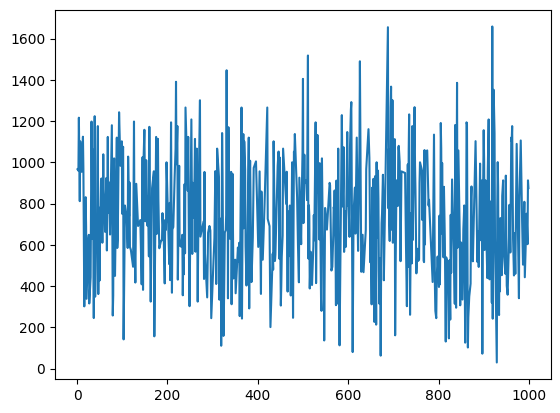

566


In [222]:
# plot initial_batch unit_distance_11
plt.plot(initial_batch[initial_batch['unit_distance_11'] < 1e6]['unit_distance_11'])
plt.show()
print(len(initial_batch[initial_batch['unit_distance_11'] < 1e6]['unit_distance_11']))

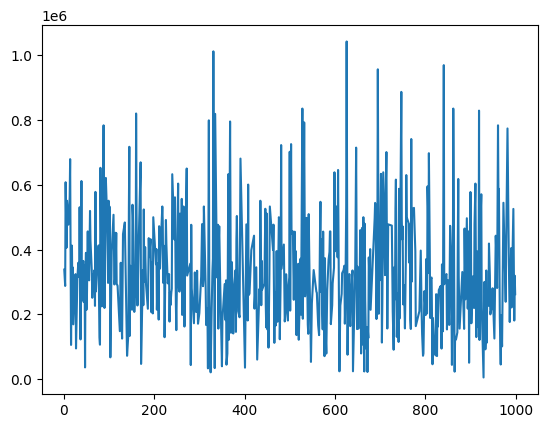

566


In [221]:
# plot initial_batch unit_weighted_distance_11
plt.plot(initial_batch[initial_batch['unit_weighted_distance_11'] < 1e9]['unit_weighted_distance_11'])
plt.show()
print(len(initial_batch[initial_batch['unit_weighted_distance_11'] < 1e9]['unit_weighted_distance_11']))

3. Drop the columns that are not needed:
- all columns with player1 or player0 in the name 
- colour columns


In [147]:
def drop_no_longer_needed_columns(data):
    # drop all columns with player1 or player0 in the name.
    data = data.drop(columns=[col for col in data.columns if 'player0' in col or 'player1' in col])
    data = data.drop(columns=[col for col in data.columns if 'colour' in col])
    return data

In [148]:
initial_batch = drop_no_longer_needed_columns(initial_batch)

In [149]:
initial_batch.columns

Index(['map_id', 'game_mode', 'moving_player', 'moving_AI', 'hp_moving_unit1',
       'position_x_moving_unit1', 'position_y_moving_unit1',
       'moving_unit1_type', 'hp_moving_unit2', 'position_x_moving_unit2',
       'position_y_moving_unit2', 'moving_unit2_type', 'hp_moving_unit3',
       'position_x_moving_unit3', 'position_y_moving_unit3',
       'moving_unit3_type', 'hp_moving_unit4', 'position_x_moving_unit4',
       'position_y_moving_unit4', 'moving_unit4_type', 'target_AI',
       'hp_target_unit1', 'position_x_target_unit1', 'position_y_target_unit1',
       'target_unit1_type', 'hp_target_unit2', 'position_x_target_unit2',
       'position_y_target_unit2', 'target_unit2_type', 'hp_target_unit3',
       'position_x_target_unit3', 'position_y_target_unit3',
       'target_unit3_type', 'hp_target_unit4', 'position_x_target_unit4',
       'position_y_target_unit4', 'target_unit4_type', 'moving_player_deads',
       'moving_player_total_hp', 'target_player_deads',
       'targ

In [150]:
initial_batch['moving_AI'] = initial_batch['moving_AI'].astype(bool)
initial_batch['target_AI'] = initial_batch['target_AI'].astype(bool)

In [151]:
initial_batch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 73 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   map_id                     1000 non-null   object 
 1   game_mode                  1000 non-null   object 
 2   moving_player              1000 non-null   int64  
 3   moving_AI                  1000 non-null   bool   
 4   hp_moving_unit1            1000 non-null   float64
 5   position_x_moving_unit1    1000 non-null   float64
 6   position_y_moving_unit1    1000 non-null   float64
 7   moving_unit1_type          1000 non-null   object 
 8   hp_moving_unit2            1000 non-null   float64
 9   position_x_moving_unit2    1000 non-null   float64
 10  position_y_moving_unit2    1000 non-null   float64
 11  moving_unit2_type          1000 non-null   object 
 12  hp_moving_unit3            1000 non-null   float64
 13  position_x_moving_unit3    1000 non-null   float6

4. One hot encode categorical columns, make sure that numeric columns have numeric dtype

In [152]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_categorical(data, one_hot_encoder=None):
    # change dtype from bool to int for moving_AI and target_AI
    data['moving_AI'] = data['moving_AI'].astype(int)
    data['target_AI'] = data['target_AI'].astype(int)

    categorical_columns = ['map_id', 'game_mode', 'moving_unit1_type', 'moving_unit2_type', 'moving_unit3_type', 'moving_unit4_type', 'target_unit1_type', 'target_unit2_type', 'target_unit3_type', 'target_unit4_type']
    if one_hot_encoder is None:
        one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
        one_hot_encoder.fit(data[categorical_columns])
    one_hot_encoded = one_hot_encoder.transform(data[categorical_columns]).toarray()
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
    data = data.drop(columns=categorical_columns)
    data = pd.concat([data, one_hot_encoded], axis=1)

    return data, one_hot_encoder

In [153]:
initial_batch, one_hot_encoder = one_hot_encode_categorical(initial_batch)
initial_batch.dtypes[:10]

moving_player                int64
moving_AI                    int64
hp_moving_unit1            float64
position_x_moving_unit1    float64
position_y_moving_unit1    float64
hp_moving_unit2            float64
position_x_moving_unit2    float64
position_y_moving_unit2    float64
hp_moving_unit3            float64
position_x_moving_unit3    float64
dtype: object

In [154]:
def preprocess(data, one_hot_encoder=None):
    data = transform_to_moving_target_player(data)
    data = add_dead_counts_and_total_hp(data)
    data = add_units_distance(data)
    data= drop_no_longer_needed_columns(data)
    data, one_hot_encoder = one_hot_encode_categorical(data, one_hot_encoder)
    return data, one_hot_encoder

In [155]:
pool_data, _ = preprocess(pool_data, one_hot_encoder)
pool_data.shape

(5000, 121)

The model used for evaluation has exactly parameters like one below

In [157]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators = 300,
                      max_depth = 8,
                      learning_rate = 0.01,
                      booster = 'gbtree',
                      objective = 'binary:logistic',
                      tree_method = 'exact',
                      min_child_weight = 1,
                      subsample = 1.0,
                      colsample_bytree = 1.0,
                      reg_alpha = 1,
                      reg_lambda = 5,
                      eval_metric = 'auc',
                      )


In [158]:
model.fit(initial_batch, y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [160]:
y.value_counts()

False    813
True     187
Name: frag, dtype: int64

In [161]:
#get number of False values in y
y_n_false = y.value_counts()[0]
y_n_true = y.value_counts()[1]

I tried using modAL library, but found it troublesome.

In [163]:
# # Try out all sampling methods from modAl
# from modAL.models import ActiveLearner
# from modAL.uncertainty import *
# from modAL.batch import *
# from modAL.disagreement import *
# from modAL.density import *
# from modAL.expected_error import *
# from modAL.multilabel import *
# from modAL.uncertainty import *
# from modAL.models import ActiveLearner, Committee
# from modAL.disagreement import vote_entropy_sampling, max_disagreement_sampling, consensus_entropy_sampling, max_std_sampling

# def sample_and_save(query_strategy):
#     # initializing the learner
#     learner = ActiveLearner(
#         estimator=model,
#         query_strategy=query_strategy,
#         X_training=initial_batch.values, y_training=y.values
#     )

#     # query for labels
#     query_idx_small, query_inst_small = learner.query(pool_data.values, n_instances=50)
#     query_idx_big, query_inst_big = learner.query(pool_data.values, n_instances=200)

#     # save query_idx to text file in one line separated by commas
#     with open(query_strategy.__name__ + '.txt', 'w') as f:
#         f.write(','.join([str(idx+1) for idx in query_idx_small]))
#         f.write('\n')
#         f.write(','.join([str(idx+1) for idx in query_idx_big]))

# sample_and_save(uncertainty_sampling)
# sample_and_save(entropy_sampling)
# sample_and_save(margin_sampling)
# sample_and_save(uncertainty_batch_sampling)
# sample_and_save(consensus_entropy_sampling)
# # sample_and_save(max_std_sampling)


In [164]:
# # Do Bootstrapping and bagging using modAL
# from modAL.models import ActiveLearner, Committee
# from modAL.disagreement import vote_entropy_sampling, max_disagreement_sampling, consensus_entropy_sampling, max_std_sampling

# # initializing Committee members
# n_members = 2
# learner_list = list()

# for member_idx in range(n_members):
#     # initial training data
#     n_initial = 100
#     train_idx = np.random.choice(range(X.shape[0]), size=n_initial, replace=False)
#     X_train = X[train_idx]
#     y_train = y[train_idx]

#     # creating a reduced copy of the data with the known instances removed
#     X_pool = np.delete(X, train_idx, axis=0)
#     y_pool = np.delete(y, train_idx)

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training=y_train
#     )
#     learner_list.append(learner)

# # assembling the committee
# committee = Committee(
#     learner_list=learner_list,
#     query_strategy=max_disagreement_sampling
# )




Different uncertainty functions. Ended up using my_uncertainty with peak at y_n_false/(y_n_false + y_n_true) probability

In [273]:
# Write active learning from scratch

def entropy_uncertainty(predictions_probabilities: np.ndarray) -> np.ndarray:
  # return the entropy of the predictions
  return -np.sum(predictions_probabilities * np.log(predictions_probabilities), axis=1)

def margin_uncertainty(predictions_probabilities: np.ndarray) -> np.ndarray:
  # return the margin of the predictions
  return np.max(predictions_probabilities, axis=1) - np.partition(predictions_probabilities, -2, axis=1)[:, -2]

def random_uncertainty(predictions_probabilities: np.ndarray) -> np.ndarray:
  # return random values
  return np.random.rand(predictions_probabilities.shape[0])

def least_confidence_uncertainty(predictions_probabilities: np.ndarray) -> np.ndarray:
  # return the least confidence of the predictions
  return 1 - np.max(predictions_probabilities, axis=1)

def my_uncertainty(predictions_probabilities: np.ndarray) -> np.ndarray:
  # return the least confidence of the predictions
  return 1 - np.absolute(predictions_probabilities[:, 0] - y_n_false/(y_n_false + y_n_true))

def uniform_uncertainty(predictions_probabilities: np.ndarray) -> np.ndarray:
  # return the entropy of the predictions
  return np.ones(predictions_probabilities.shape[0])

def skewed_entropy_uncertainty(predictions_probabilities: np.ndarray) -> np.ndarray:
    skew_false = y_n_false/(y_n_false + y_n_true)
    skew_true = y_n_true/(y_n_false + y_n_true)
    c = np.array((predictions_probabilities[:, 0] / skew_false, predictions_probabilities[:, 1] / skew_true))
    predictions_probabilities = c.T / np.sum(c.T, axis=1, keepdims=True)
    return -np.sum(predictions_probabilities * np.log(predictions_probabilities), axis=1)


/tmp/ipykernel_31272/1608887882.py:44: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(y_prob * np.log2(y_prob), axis=1)
/tmp/ipykernel_31272/1608887882.py:44: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y_prob * np.log2(y_prob), axis=1)


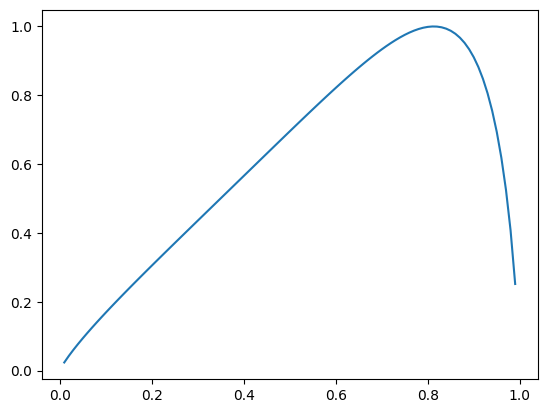

In [314]:
probs = np.arange(0, 1, 0.01)
probs2 = 1-probs

target_dist = np.array([813/1000, 187/1000])

plt.plot(probs, skewed_entropy_uncertainty(np.array([probs, probs2]).T,))
plt.show()

Functions for sampling using uncertainty.

In [166]:
def select_next_samples_indices(
    clf,
    unlabeled_data: pd.DataFrame,
    uncertainty_measure: Callable[[np.ndarray], np.ndarray],
    n_samples: int = 1
) -> Tuple[List[int], pd.DataFrame]:
  # select n_samples from unlabeled data using uncertainty_measure
  predictions_probabilities = clf.predict_proba(unlabeled_data)
  uncertainty = uncertainty_measure(predictions_probabilities)
  selected_indices = np.argsort(uncertainty)[-n_samples:]
  return selected_indices


def sample_and_safe_from_scratch(query_strategy):
    small_indices= select_next_samples_indices(model, pool_data, query_strategy, 50)
    big_indices = select_next_samples_indices(model, pool_data, query_strategy, 200)

    # save query_idx to text file in one line separated by commas
    with open(query_strategy.__name__ + '_from_scratch.txt', 'w') as f:
        f.write(','.join([str(idx+1) for idx in small_indices]))
        f.write('\n')
        f.write(','.join([str(idx+1) for idx in big_indices]))


In [275]:
sample_and_safe_from_scratch(entropy_uncertainty)
sample_and_safe_from_scratch(margin_uncertainty)
sample_and_safe_from_scratch(random_uncertainty)
sample_and_safe_from_scratch(least_confidence_uncertainty)
sample_and_safe_from_scratch(my_uncertainty)
sample_and_safe_from_scratch(skewed_entropy_uncertainty)

Similarity functions for sampling using uncertainty + knn similarity.

In [200]:
def cosine_similarity(data: pd.DataFrame, sample) -> np.ndarray:
    # compute cosine similarity to all other samples
    cosine_similarities = np.dot(data, sample) / (np.linalg.norm(data, axis=1) * np.linalg.norm(sample))
    return cosine_similarities


def euclidian_similarity(data: pd.DataFrame, sample) -> np.ndarray:
    # compute euclidian distance to all other samples
    euclidian_distances = np.linalg.norm(data - sample, axis=1)
    euclidian_similarities = 1 / (1 + euclidian_distances)
    return euclidian_similarities


def get_similarity(data, similarity_measure, number_of_neighbours):
  average_similarities = np.zeros(data.shape[0])

  for i, sample in data.iterrows():
    # compute cosine similarity to all other samples
    similarities = similarity_measure(data, sample)
    # sort by similarity
    sorted_indices = np.argsort(similarities)
    # take 5 nearest neighbors
    nearest_neighbors = similarities[sorted_indices[-number_of_neighbours:]]
    # compute average similarity
    average_similarities[i] = np.mean(nearest_neighbors)

  return average_similarities

In [201]:
pool_data_normalized = (pool_data - pool_data.mean(axis=0)) / pool_data.std(axis=0)

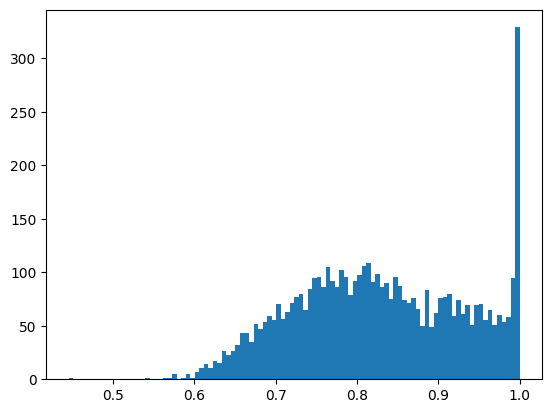

In [202]:
cosine_similarities = get_similarity(pool_data_normalized, cosine_similarity, 5)
plt.hist(cosine_similarities, bins=100)
plt.show()

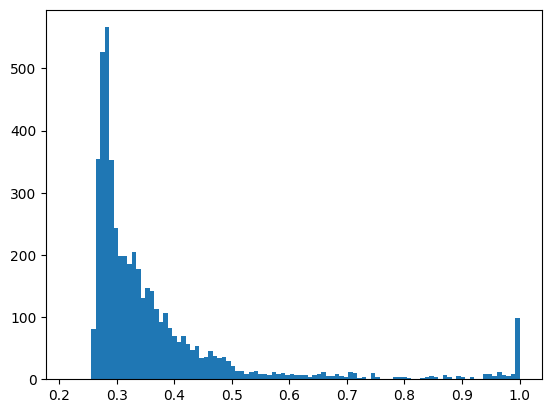

In [203]:
euclidian_similarities = get_similarity(pool_data_normalized, euclidian_similarity, 5)
plt.hist(euclidian_similarities, bins=100)
plt.show()

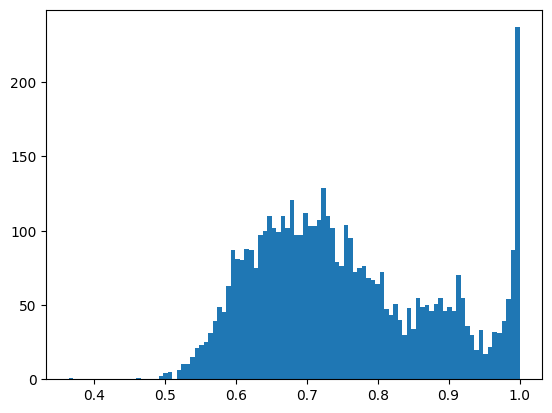

In [204]:
cosine_similarities = get_similarity(pool_data_normalized, cosine_similarity, 10)
plt.hist(cosine_similarities, bins=100)
plt.show()

In [313]:
def select_with_similarity(
    clf,
    unlabeled_data: pd.DataFrame,
    uncertainty_measure: Callable[[np.ndarray], np.ndarray],
    similarity_measure,
    number_of_neighbours,
    n_samples: int = 1,
    alpha: float = 1/2
) -> Tuple[List[int], pd.DataFrame]:
  # select n_samples from unlabeled data using uncertainty_measure
  predictions_probabilities = clf.predict_proba(unlabeled_data)
  uncertainty = uncertainty_measure(predictions_probabilities)
  pool_data_normalized = (pool_data - pool_data.mean(axis=0)) / pool_data.std(axis=0)
  similarities = get_similarity(pool_data_normalized, similarity_measure, number_of_neighbours)
  informativeness = uncertainty * (similarities**(alpha))

  selected_indices = np.argsort(informativeness)[-n_samples:]
  return selected_indices


def sample_and_safe_with_similarity(query_strategy, similarity_measure, number_of_neighbours):
    small_indices= select_with_similarity(model, pool_data, query_strategy, similarity_measure, number_of_neighbours, 50)
    big_indices = select_with_similarity(model, pool_data, query_strategy, similarity_measure, number_of_neighbours, 200)

    # save query_idx to text file in one line separated by commas
    with open(f'{query_strategy.__name__}_with_{similarity_measure.__name__}_{number_of_neighbours}_neighbours.txt', 'w') as f:
        f.write(','.join([str(idx+1) for idx in small_indices]))
        f.write('\n')
        f.write(','.join([str(idx+1) for idx in big_indices]))

In [312]:
# sample_and_safe_with_similarity(my_uncertainty, euclidian_similarity)
sample_and_safe_with_similarity(my_uncertainty, cosine_similarity, 5)
# alpha 1/2 - 3.6377

In [276]:
# sample_and_safe_with_similarity(skewed_entropy_uncertainty, cosine_similarity, 5)

Distance functions for sampling using uncertainty + knn similarity + distance representativeness.

In [291]:
def cosine_distance(data: pd.DataFrame, sample) -> np.ndarray:
    # compute cosine similarity to all other samples
    cosine_similarities = np.dot(data, sample) / (np.linalg.norm(data, axis=1) * np.linalg.norm(sample))
    cosine_distances = 1 - cosine_similarities
    return cosine_distances


def euclidian_distance(data: pd.DataFrame, sample) -> np.ndarray:
    # compute euclidian distance to all other samples
    euclidian_distances = np.linalg.norm(data - sample, axis=1)
    return euclidian_distances


def get_distance_to_selected_indices(data: pd.DataFrame, distance_measure, selected_indices):
    average_distances = np.zeros(data.shape[0])

    # data to numpy array
    data = data.to_numpy()
    selected_data = data[selected_indices]
    
    for row_i in range(data.shape[0]):
        if row_i not in selected_indices:     
          distances = distance_measure(selected_data, data[row_i])
          average_distances[row_i] = np.mean(distances)

    return average_distances

In [308]:
def select_with_similarity_and_dissimilarity(
    clf,
    unlabeled_data: pd.DataFrame,
    uncertainty_measure: Callable[[np.ndarray], np.ndarray],
    similarity_measure,
    distance_measure,
    number_of_neighbours,
    n_samples: int = 1,
    alpha: float = 1/2,
    beta: float = 1
) -> Tuple[List[int], pd.DataFrame]:
  # select n_samples from unlabeled data using uncertainty_measure
  unlabeled_data_normalized = (unlabeled_data - unlabeled_data.mean(axis=0)) / unlabeled_data.std(axis=0)
  predictions_probabilities = clf.predict_proba(unlabeled_data)
  uncertainty = uncertainty_measure(predictions_probabilities)
  similarities = get_similarity(unlabeled_data_normalized, similarity_measure, number_of_neighbours)

  informativeness = uncertainty * similarities
  next_index = np.argsort(informativeness)[-1]
  selected_indices = [next_index]

  for _ in range(n_samples - 1):
    distances = get_distance_to_selected_indices(unlabeled_data_normalized, distance_measure, selected_indices)
    informativeness = uncertainty * (similarities**(alpha)) * (distances**(beta))
    next_index = np.argsort(informativeness)[-1]
    selected_indices.append(next_index)

  return selected_indices


def sample_and_safe_with_similarity_and_dissimilarity(query_strategy, similarity_measure, distance_measure, number_of_neighbours):
    small_indices= select_with_similarity_and_dissimilarity(model, pool_data, query_strategy, similarity_measure, distance_measure, number_of_neighbours, 50)
    big_indices = select_with_similarity_and_dissimilarity(model, pool_data, query_strategy, similarity_measure, distance_measure, number_of_neighbours, 200)

    # save query_idx to text file in one line separated by commas
    with open(f'{query_strategy.__name__}_with_{similarity_measure.__name__}_{number_of_neighbours}_neighbours_and_{distance_measure.__name__}.txt', 'w') as f:
        f.write(','.join([str(idx+1) for idx in small_indices]))
        f.write('\n')
        f.write(','.join([str(idx+1) for idx in big_indices]))

In [309]:
sample_and_safe_with_similarity_and_dissimilarity(my_uncertainty, cosine_similarity, cosine_distance, 5)

In [298]:
# sample_and_safe_with_similarity_and_dissimilarity(my_uncertainty, cosine_similarity, euclidian_distance, 5)

Final 2 solutions use:
1. my_uncertainty + 5nn similarity with alpha = 1/2, cosine similarity.
2. my_uncertainty + 5nn similarity with alpha = 1, cosine similarity + distance representativeness beta = 1, cosine distance.